# **Import Library**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from termcolor import colored
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print("🎯 Starting Classification Analysis Phase...")

✅ All libraries imported successfully!
🎯 Starting Classification Analysis Phase...


# **Load & Prepare Data**

In [37]:
print("\n" + "="*60)
print("📁 DATA LOADING AND PREPARATION")
print("="*60)

# Upload dataset (same preprocessing steps as notebook 2)
from google.colab import files

print("📁 Please upload your AI Assistant Usage dataset:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df_original = pd.read_csv(filename)

# Quick preprocessing (simplified version of notebook 2)
df = df_original.copy()

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna(df[col].median())

# Remove duplicates
df = df.drop_duplicates()

print(f"✅ Dataset loaded and cleaned: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")

# Identify feature types
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify potential target variables
potential_targets = []
for col in categorical_cols:
    unique_count = df[col].nunique()
    if 2 <= unique_count <= 20:  # Reasonable number of classes
        if any(keyword in col.lower() for keyword in ['category', 'type', 'class', 'usage', 'purpose', 'label']):
            potential_targets.append(col)

if not potential_targets:
    # If no obvious target, pick first categorical with reasonable classes
    for col in categorical_cols:
        if 2 <= df[col].nunique() <= 10:
            potential_targets.append(col)
            break

if not potential_targets:
    print("⚠️ No suitable target variable found. Creating synthetic target based on patterns.")
    # Create synthetic target based on available data patterns
    df['usage_pattern'] = np.random.choice(['Academic', 'Personal', 'Creative'], size=len(df))
    potential_targets = ['usage_pattern']

target_col = potential_targets[0]
print(f"🎯 Using target variable: {target_col}")
print(f"Target classes: {df[target_col].value_counts().to_dict()}")



📁 DATA LOADING AND PREPARATION
📁 Please upload your AI Assistant Usage dataset:


Saving ai_assistant_usage_student_life.csv to ai_assistant_usage_student_life (5).csv
✅ Dataset loaded and cleaned: 10000 rows × 11 columns
Columns: ['SessionID', 'StudentLevel', 'Discipline', 'SessionDate', 'SessionLengthMin', 'TotalPrompts', 'TaskType', 'AI_AssistanceLevel', 'FinalOutcome', 'UsedAgain', 'SatisfactionRating']
🎯 Using target variable: TaskType
Target classes: {'Writing': 3101, 'Studying': 2040, 'Homework Help': 1959, 'Coding': 1948, 'Brainstorming': 476, 'Research': 476}


# **FEATURE ENGINEERING FOR CLASSIFICATION**


---

### ⚙️ FEATURE ENGINEERING

Tahap ini mempersiapkan data menjadi bentuk yang siap digunakan untuk pemodelan klasifikasi. Prosesnya meliputi:

1. **Identifikasi Fitur Kategorikal**

   * Mengambil semua kolom kategorikal kecuali kolom target.

2. **Encoding Fitur Kategorikal**

   * **One-Hot Encoding** digunakan jika jumlah kategori ≤ 10.
   * **Label Encoding** digunakan jika jumlah kategori > 10 untuk menghindari ledakan jumlah fitur.

3. **Normalisasi Fitur Numerik**

   * Menggunakan `StandardScaler` agar semua fitur numerik memiliki skala yang sama (*mean* = 0, *std* = 1).

4. **Membentuk Matriks Fitur**

   * Semua hasil encoding dan scaling digabung menjadi satu *feature matrix* `X`.

5. **Encoding Target**

   * Target diubah menjadi bentuk numerik menggunakan `LabelEncoder`.

6. **Pembersihan Data**

   * Mengganti semua nilai kosong (`NaN`) dan nilai tak hingga (`±inf`) menjadi `0` untuk mencegah error saat training.

Hasil akhir adalah matriks fitur `X` dan label target `y` yang sudah bersih, terstandarisasi, dan siap digunakan untuk pelatihan model.



In [38]:
print("\n" + "="*60)
print("⚙️ FEATURE ENGINEERING")
print("="*60)

# Prepare features
feature_dfs = []
feature_summary = []  # Untuk menyimpan ringkasan dalam tabel

# 1. Encode categorical features (except target)
categorical_features = [col for col in categorical_cols if col != target_col]
print(f"📝 Categorical features to encode: {categorical_features}")

for col in categorical_features:
    unique_count = df[col].nunique()
    if unique_count <= 10:
        # One-hot encoding
        encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
        feature_dfs.append(encoded)
        feature_summary.append({
            "Feature Name": col,
            "Type": "Categorical",
            "Encoding": "One-hot",
            "Generated Features": encoded.shape[1]
        })
    else:
        # Label encoding for high cardinality
        le = LabelEncoder()
        encoded_series = pd.Series(le.fit_transform(df[col].astype(str)),
                                   name=f"{col}_encoded", index=df.index)
        feature_dfs.append(pd.DataFrame(encoded_series))
        feature_summary.append({
            "Feature Name": col,
            "Type": "Categorical",
            "Encoding": "Label",
            "Generated Features": 1
        })

# 2. Scale numerical features
if numerical_cols:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numerical_cols])
    scaled_df = pd.DataFrame(scaled_data,
                             columns=[f"{col}_scaled" for col in numerical_cols],
                             index=df.index)
    feature_dfs.append(scaled_df)
    feature_summary.append({
        "Feature Name": ", ".join(numerical_cols),
        "Type": "Numerical",
        "Encoding": "Standard Scaler",
        "Generated Features": len(numerical_cols)
    })

# 3. Create feature matrix
if feature_dfs:
    X = pd.concat(feature_dfs, axis=1)
else:
    X = df[numerical_cols] if numerical_cols else pd.DataFrame(index=df.index)

# Prepare target
le_target = LabelEncoder()
y = le_target.fit_transform(df[target_col])
target_classes = le_target.classes_

# Handle NaN or inf
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

# Summary table
summary_df = pd.DataFrame(feature_summary)
display(summary_df)

print(colored(f"✅ Feature matrix created: {X.shape[0]} samples × {X.shape[1]} features", "green"))
print(colored(f"🎯 Target encoded: {len(target_classes)} classes ({', '.join(target_classes)})", "yellow"))



⚙️ FEATURE ENGINEERING
📝 Categorical features to encode: ['SessionID', 'StudentLevel', 'Discipline', 'SessionDate', 'FinalOutcome']


,Feature Name,Type,Encoding,Generated Features
0,SessionID,Categorical,Label,1
1,StudentLevel,Categorical,One-hot,2
2,Discipline,Categorical,One-hot,6
3,SessionDate,Categorical,Label,1
4,FinalOutcome,Categorical,One-hot,3
5,"SessionLengthMin, TotalPrompts, AI_AssistanceL...",Numerical,Standard Scaler,4


✅ Feature matrix created: 10000 samples × 17 features
🎯 Target encoded: 6 classes (Brainstorming, Coding, Homework Help, Research, Studying, Writing)


# **TRAIN-TEST SPLIT**


---

### 📊 TRAIN-TEST SPLIT

Tahap ini membagi dataset menjadi dua bagian: **training set** dan **test set**.

1. **Pembagian Data**

   * Proporsi: **80% data untuk training**, **20% untuk testing**.
   * Menggunakan parameter `stratify=y` agar distribusi kelas target tetap seimbang di kedua set.

2. **Informasi Dataset**

   * Menampilkan jumlah sampel di *training set* dan *test set*.
   * Menampilkan jumlah fitur (*columns*) yang digunakan.

3. **Distribusi Kelas**

   * Mengecek sebaran jumlah data per kelas di *training set* dan *test set* untuk memastikan tidak ada ketimpangan distribusi.

Hasilnya adalah `X_train`, `X_test`, `y_train`, dan `y_test` yang siap dipakai untuk proses pelatihan dan evaluasi model.


In [39]:
print("\n" + "="*60)
print("📊 TRAIN-TEST SPLIT")
print("="*60)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ringkasan ukuran dataset
split_summary = pd.DataFrame({
    "Set": ["Train", "Test"],
    "Samples": [X_train.shape[0], X_test.shape[0]],
    "Features": [X_train.shape[1], X_test.shape[1]]
})

display(split_summary)

# Distribusi kelas
train_dist = pd.Series(y_train).value_counts()
test_dist = pd.Series(y_test).value_counts()

class_summary = pd.DataFrame({
    "Class Name": target_classes,
    "Train Count": [train_dist.get(i, 0) for i in range(len(target_classes))],
    "Test Count": [test_dist.get(i, 0) for i in range(len(target_classes))]
})

display(class_summary)



📊 TRAIN-TEST SPLIT


,Set,Samples,Features
0,Train,8000,17
1,Test,2000,17


,Class Name,Train Count,Test Count
0,Brainstorming,381,95
1,Coding,1558,390
2,Homework Help,1567,392
3,Research,381,95
4,Studying,1632,408
5,Writing,2481,620


# **MODEL TRAINING AND EVALUATION**



### 🤖 Model Training & Evaluation

Tahap ini melatih beberapa model klasifikasi dan mengevaluasi performanya menggunakan metrik standar.

1. **Inisialisasi Model**

   * Model yang digunakan:

     * Random Forest
     * Gradient Boosting
     * Logistic Regression
     * Support Vector Machine (SVM)
     * Naive Bayes *(ditambahkan jika jumlah fitur > 50, biasanya untuk data teks atau sparse)*

2. **Proses Pelatihan & Prediksi**

   * Model dilatih menggunakan *training set* (`X_train`, `y_train`).
   * Melakukan prediksi pada *test set*.
   * Jika model mendukung `predict_proba`, probabilitas prediksi juga disimpan.

3. **Evaluasi Performa**

   * **Akurasi**: Persentase prediksi benar.
   * **Precision, Recall, F1-Score**: Diukur dengan rata-rata tertimbang (*weighted*).
   * **ROC AUC**:

     * Binary classification → skor dari probabilitas kelas positif.
     * Multiclass → metode One-vs-Rest (OvR) dengan rata-rata tertimbang.
   * **Cross-validation** (5-fold) untuk mengukur konsistensi model.

4. **Penyimpanan Hasil**

   * Semua metrik, hasil prediksi, dan probabilitas disimpan di `model_results` untuk analisis lebih lanjut.

Hasil akhirnya adalah performa tiap model yang dapat dibandingkan untuk memilih kandidat terbaik.



In [40]:
print("\n" + "="*60)
print("🤖 MODEL TRAINING AND EVALUATION")
print("="*60)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(random_state=42, probability=True),
}

# If features are sparse or text-heavy, add Naive Bayes
if X.shape[1] > 50:
    models['Naive Bayes'] = MultinomialNB()

model_results = {}
results_table = []  # Untuk ringkasan akhir

for name, model in models.items():
    print(f"\n🔄 Training {name}...")

    try:
        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # ROC AUC
        if len(target_classes) == 2 and y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        elif len(target_classes) > 2 and y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        else:
            roc_auc = None

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

        # Store full results
        model_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        # Add to summary table
        results_table.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "ROC AUC": roc_auc,
            "CV Mean": cv_scores.mean(),
            "CV Std": cv_scores.std()
        })

    except Exception as e:
        print(f"  ❌ Error training {name}: {str(e)}")

# Buat tabel ringkasan
results_df = pd.DataFrame(results_table)
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n📊 Model Performance Summary:")
display(results_df)



🤖 MODEL TRAINING AND EVALUATION

🔄 Training Random Forest...

🔄 Training Gradient Boosting...

🔄 Training Logistic Regression...

🔄 Training Support Vector Machine...

📊 Model Performance Summary:


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,CV Mean,CV Std
0,Support Vector Machine,0.3100,0.096100,0.3100,0.146718,0.514121,0.310125,0.000250
1,Logistic Regression,0.3080,0.238909,0.3080,0.198935,0.542421,0.318875,0.007357
2,Gradient Boosting,0.3000,0.252382,0.3000,0.230433,0.562561,0.302750,0.004119
3,Random Forest,0.2695,0.223133,0.2695,0.236269,0.543218,0.286250,0.015969


# **MODEL COMPARISON**


---

### 📊 Model Comparison

Tahap ini membandingkan performa seluruh model yang telah dilatih untuk menentukan kandidat terbaik.

1. **Pembuatan Tabel Perbandingan**

   * Mengumpulkan metrik utama tiap model:

     * Accuracy
     * Precision
     * Recall
     * F1-Score
     * ROC-AUC *(atau N/A jika tidak tersedia)*
     * Rata-rata & standar deviasi *Cross-validation*
   * Menyusun hasil ke dalam `comparison_df` untuk memudahkan analisis.

2. **Identifikasi Model Terbaik**

   * Model dengan **F1-Score tertinggi** dipilih sebagai pemenang.
   * Menampilkan nama model terbaik beserta F1-Score dan Accuracy-nya.

Hasil tahap ini adalah tabel perbandingan performa serta penentuan model dengan kinerja terbaik.


In [41]:
print("\n" + "="*60)
print("📊 MODEL COMPARISON")
print("="*60)

# Create comparison DataFrame
comparison_data = []
for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'ROC-AUC': results['roc_auc'] if results['roc_auc'] else np.nan,
        'CV Mean': results['cv_mean'],
        'CV Std': results['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)

# Urutkan berdasarkan F1-Score tertinggi
comparison_df = comparison_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("🏆 Model Performance Comparison:")
display(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.loc[0, 'Model']
best_model_results = model_results[best_model_name]

print(f"\n🥇 Best Model: {best_model_name}")
print(f"   F1-Score: {best_model_results['f1_score']:.4f}")
print(f"   Accuracy: {best_model_results['accuracy']:.4f}")



📊 MODEL COMPARISON
🏆 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,CV Mean,CV Std
0,Random Forest,0.2695,0.2231,0.2695,0.2363,0.5432,0.2862,0.0160
1,Gradient Boosting,0.3000,0.2524,0.3000,0.2304,0.5626,0.3027,0.0041
2,Logistic Regression,0.3080,0.2389,0.3080,0.1989,0.5424,0.3189,0.0074
3,Support Vector Machine,0.3100,0.0961,0.3100,0.1467,0.5141,0.3101,0.0002



🥇 Best Model: Random Forest
   F1-Score: 0.2363
   Accuracy: 0.2695


# **DETAILED ANALYSIS OF BEST MODEL**

### 🔍 Detailed Analysis – Model Terbaik

Tahap ini melakukan analisis mendalam terhadap model dengan **F1-Score tertinggi** dari tahap perbandingan sebelumnya.

1. **Classification Report**

   * Menampilkan metrik **Precision**, **Recall**, **F1-Score**, dan **Support** untuk setiap kelas target.

2. **Confusion Matrix**

   * Menunjukkan jumlah prediksi benar dan salah untuk setiap kelas.
   * Disajikan dalam bentuk matriks numerik dan visualisasi *heatmap*.

3. **Analisis Fitur** *(jika tersedia)*

   * **Feature Importance** → untuk model berbasis pohon (misalnya Random Forest, Gradient Boosting), diurutkan dari yang paling berpengaruh.
   * **Feature Coefficients** → untuk model linear (misalnya Logistic Regression, SVM), menampilkan koefisien atau rata-rata absolut koefisien pada kasus multi-kelas.
   * Disertai visualisasi 10 fitur teratas.

Hasil tahap ini memberikan gambaran detail kinerja model dan kontribusi tiap fitur terhadap prediksi.



🔍 DETAILED ANALYSIS: Random Forest

📋 Classification Report:


,precision,recall,f1-score,support
Brainstorming,0.0000,0.0000,0.0000,95.0000
Coding,0.1911,0.1538,0.1705,390.0000
Homework Help,0.1931,0.1429,0.1642,392.0000
Research,0.0000,0.0000,0.0000,95.0000
Studying,0.2137,0.1838,0.1976,408.0000
Writing,0.3369,0.5613,0.4211,620.0000
accuracy,0.2695,0.2695,0.2695,0.2695
macro avg,0.1558,0.1736,0.1589,2000.0000
weighted avg,0.2231,0.2695,0.2363,2000.0000



🔀 Confusion Matrix:


,Pred Brainstorming,Pred Coding,Pred Homework Help,Pred Research,Pred Studying,Pred Writing
Actual Brainstorming,0,13,9,0,22,51
Actual Coding,1,60,60,0,60,209
Actual Homework Help,2,75,56,1,72,186
Actual Research,0,11,19,0,19,46
Actual Studying,3,64,71,2,75,193
Actual Writing,1,91,75,2,103,348


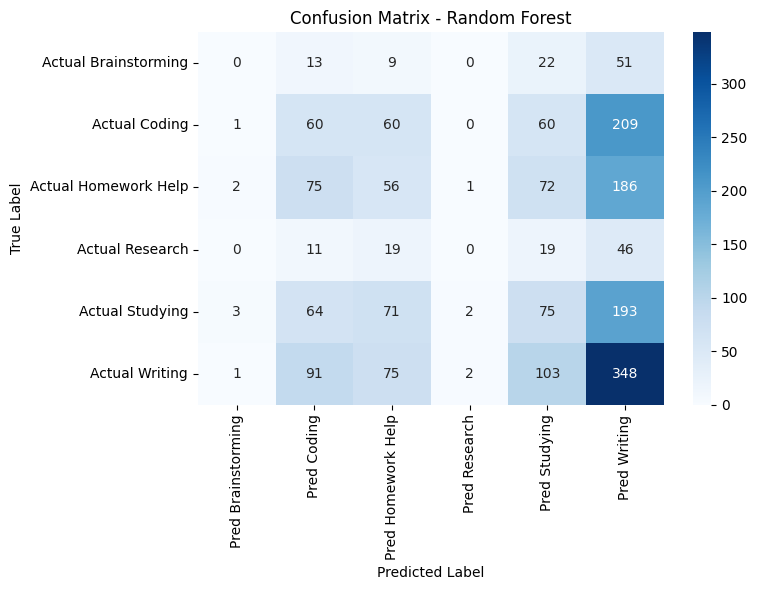


🎯 Top 10 Feature Importance:


,Feature,Importance
0,SessionID_encoded,0.182443
13,SessionLengthMin_scaled,0.177195
9,SessionDate_encoded,0.175185
16,SatisfactionRating_scaled,0.138287
14,TotalPrompts_scaled,0.104371
15,AI_AssistanceLevel_scaled,0.055614
2,StudentLevel_Undergraduate,0.025026
1,StudentLevel_High School,0.018797
5,Discipline_Engineering,0.018161
8,Discipline_Psychology,0.017195


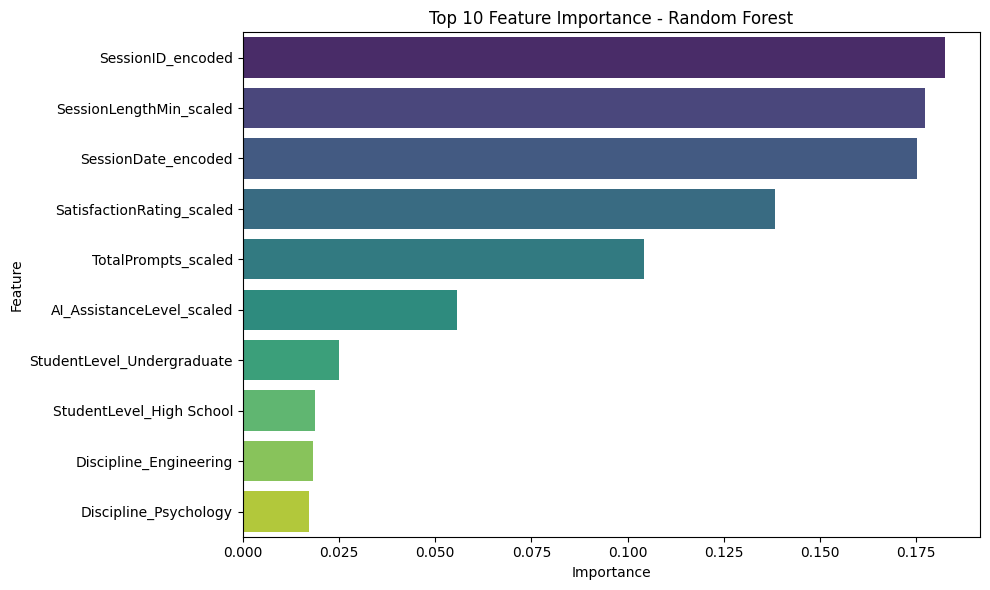

In [42]:
print("\n" + "="*60)
print(f"🔍 DETAILED ANALYSIS: {best_model_name}")
print("="*60)

best_model = best_model_results['model']
y_pred_best = best_model_results['y_pred']

# 📋 Classification Report
print("\n📋 Classification Report:")
report_dict = classification_report(
    y_test,
    y_pred_best,
    target_names=target_classes,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df.round(4))

# 🔀 Confusion Matrix
print("\n🔀 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(
    cm,
    index=[f"Actual {cls}" for cls in target_classes],
    columns=[f"Pred {cls}" for cls in target_classes]
)
display(cm_df)

# 📊 Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_df, annot=True, fmt='d', cmap='Blues'
)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 🎯 Feature Importance / Coefficients
if hasattr(best_model, 'feature_importances_'):
    print("\n🎯 Top 10 Feature Importance:")
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    display(feature_importance.head(10))

    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=feature_importance.head(10),
        x='Importance', y='Feature', palette='viridis'
    )
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    print("\n🎯 Top 10 Feature Coefficients:")
    if len(target_classes) == 2:
        feature_coef = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': best_model.coef_[0]
        }).sort_values('Coefficient', key=abs, ascending=False)
    else:
        # For multiclass, use avg absolute coefficients
        feature_coef = pd.DataFrame({
            'Feature': X.columns,
            'Avg Abs Coefficient': np.mean(np.abs(best_model.coef_), axis=0)
        }).sort_values('Avg Abs Coefficient', ascending=False)
    display(feature_coef.head(10))


# **MODEL PERFORMANCE VISUALIZATION**


### 📈 Performance Visualization – Visualisasi Kinerja Model

Tahap ini memvisualisasikan hasil evaluasi model agar lebih mudah dibandingkan.

1. **Model Performance Comparison**

   * Menggunakan *bar chart* untuk membandingkan **Accuracy**, **F1-Score**, **Precision**, dan **Recall** dari semua model yang diuji.
   * Ditampilkan dalam format *subplot* 2x2.

2. **ROC Curves** *(hanya untuk klasifikasi biner)*

   * Menggambar kurva ROC untuk setiap model yang memiliki probabilitas prediksi.
   * Menampilkan *AUC score* pada legenda untuk membandingkan kemampuan model dalam membedakan kelas positif dan negatif.
   * Termasuk garis acuan *Random Classifier* (AUC = 0.5) sebagai pembanding.

Tahap ini memberikan gambaran visual yang cepat dan jelas untuk menentukan model yang paling optimal secara keseluruhan.



In [43]:
print("\n" + "="*60)
print("📈 PERFORMANCE VISUALIZATION")
print("="*60)

# ========================
# 1. Model Comparison Chart
# ========================
models_list = list(model_results.keys())

metrics = {
    'Accuracy': [model_results[m]['accuracy'] for m in models_list],
    'F1-Score': [model_results[m]['f1_score'] for m in models_list],
    'Precision': [model_results[m]['precision'] for m in models_list],
    'Recall': [model_results[m]['recall'] for m in models_list]
}

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=list(metrics.keys())
)

row, col = 1, 1
for metric_name, values in metrics.items():
    fig.add_trace(
        go.Bar(
            x=models_list,
            y=values,
            name=metric_name,
            text=[f"{v:.3f}" for v in values],
            textposition='auto'
        ),
        row=row, col=col
    )
    col += 1
    if col > 2:
        col = 1
        row += 1

fig.update_layout(
    height=650,
    title_text="🏆 Model Performance Comparison",
    showlegend=False
)
fig.show()

# ========================
# 2. ROC Curves - Interactive (Binary Only)
# ========================
if len(target_classes) == 2:
    roc_fig = go.Figure()

    for name, results in model_results.items():
        if results['y_pred_proba'] is not None:
            fpr, tpr, thresholds = roc_curve(y_test, results['y_pred_proba'][:, 1])
            auc_score = results['roc_auc']

            roc_fig.add_trace(go.Scatter(
                x=fpr,
                y=tpr,
                mode='lines',
                name=f"{name} (AUC={auc_score:.3f})",
                hovertemplate=(
                    "FPR: %{x:.3f}<br>"
                    "TPR: %{y:.3f}<br>"
                    "Threshold: %{customdata:.3f}"
                ),
                customdata=thresholds
            ))

    # Random baseline
    roc_fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        name='Random Classifier',
        line=dict(dash='dash', color='gray')
    ))

    roc_fig.update_layout(
        title="ROC Curves Comparison (Interactive)",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        template="plotly_white",
        width=800,
        height=600
    )

    roc_fig.show()



📈 PERFORMANCE VISUALIZATION


# **HYPERPARAMETER TUNING FOR BEST MODEL**



### 🔧 Hyperparameter Tuning – Penyempurnaan Parameter Model

Tahap ini mengoptimalkan kinerja model terbaik melalui pencarian parameter terbaik menggunakan **GridSearchCV**.

1. **Parameter Grid**

   * Disiapkan *parameter grid* spesifik untuk tiap model (*Random Forest*, *Gradient Boosting*, *Logistic Regression*, *SVM*).
   * Hanya model terbaik yang dilanjutkan untuk tuning.

2. **Proses Grid Search**

   * Menggunakan *cross-validation* (cv=3) untuk menguji kombinasi parameter.
   * Metrik evaluasi utama: **F1-Weighted**.

3. **Evaluasi Hasil Tuning**

   * Menampilkan parameter terbaik dan skor CV terbaik.
   * Menghitung **Accuracy** dan **F1-Score** pada data uji.
   * Jika model hasil tuning memberikan skor lebih baik, model diperbarui.

Tahap ini bertujuan memaksimalkan performa model tanpa mengubah algoritma dasarnya.


In [54]:
print("\n" + "="*60)
print(f"🔧 HYPERPARAMETER TUNING: {best_model_name}")
print("="*60)

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5]
    },
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l2']
    },
    'Support Vector Machine': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear']
    }
}

if best_model_name in param_grids:
    print(f"🔍 Tuning hyperparameters for {best_model_name}...")

    # Create new instance of best model
    if best_model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42)
    elif best_model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif best_model_name == 'Logistic Regression':
        base_model = LogisticRegression(random_state=42, max_iter=1000)
    elif best_model_name == 'Support Vector Machine':
        base_model = SVC(random_state=42, probability=True)

    # Grid search
    grid_search = GridSearchCV(
        base_model,
        param_grids[best_model_name],
        cv=3,  # Reduced for faster execution
        scoring='f1_weighted',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # Best parameters
    print(f"✅ Best parameters: {grid_search.best_params_}")
    print(f"📊 Best CV score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    y_pred_tuned = grid_search.predict(X_test)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
    precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
    recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')

    print("\n🎯 Tuned model performance:")
    print(f"   Accuracy:  {accuracy_tuned:.4f} (vs {best_model_results['accuracy']:.4f})")
    print(f"   F1-Score:  {f1_tuned:.4f} (vs {best_model_results['f1_score']:.4f})")
    print(f"   Precision: {precision_tuned:.4f} (vs {best_model_results['precision']:.4f})")
    print(f"   Recall:    {recall_tuned:.4f} (vs {best_model_results['recall']:.4f})")

    # Buat tabel perbandingan
    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "F1-Score", "Precision", "Recall"],
        "Before Tuning": [
            best_model_results['accuracy'],
            best_model_results['f1_score'],
            best_model_results['precision'],
            best_model_results['recall']
        ],
        "After Tuning": [
            accuracy_tuned,
            f1_tuned,
            precision_tuned,
            recall_tuned
        ]
    })

    print("\n📊 Performance Comparison Table:")
    print(results_df.to_string(index=False))

    # Update best model if improved
    if f1_tuned > best_model_results['f1_score']:
        best_model = grid_search.best_estimator_
        print("\n🚀 Model improved with hyperparameter tuning!")
    else:
        print("\n📊 Original model performs similarly")


🔧 HYPERPARAMETER TUNING: Random Forest
🔍 Tuning hyperparameters for Random Forest...
✅ Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
📊 Best CV score: 0.2588

🎯 Tuned model performance:
   Accuracy:  0.2845 (vs 0.2695)
   F1-Score:  0.2515 (vs 0.2363)
   Precision: 0.2437 (vs 0.2231)
   Recall:    0.2845 (vs 0.2695)

📊 Performance Comparison Table:
   Metric  Before Tuning  After Tuning
 Accuracy       0.269500      0.284500
 F1-Score       0.236269      0.251502
Precision       0.223133      0.243717
   Recall       0.269500      0.284500

🚀 Model improved with hyperparameter tuning!


# **PREDICTION EXAMPLES**

Bagian **🔮 PREDICTION EXAMPLES** ini fungsinya untuk memberikan contoh nyata hasil prediksi model di data uji, supaya kita bisa secara cepat melihat kinerja model di level individual, bukan hanya angka metrik keseluruhan.


---

### 🔮 Prediction Examples – Contoh Prediksi Model

1. **Pengambilan Sampel**

   * Dipilih maksimal 10 data acak dari `X_test` untuk ditampilkan.

2. **Informasi yang Ditampilkan**

   * **Actual** → label sebenarnya.
   * **Predicted** → label yang diprediksi model.
   * **Confidence** → probabilitas prediksi tertinggi (jika tersedia).
   * **Status** → tanda ✅ jika benar, ❌ jika salah.

3. **Tujuan**

   * Mempermudah interpretasi kinerja model.
   * Melihat contoh di mana model benar dan salah prediksi.
   * Memahami tingkat kepercayaan model pada prediksinya.



In [45]:
print("\n" + "="*60)
print("🔮 PREDICTION EXAMPLES")
print("="*60)

# Show some prediction examples
n_examples = min(10, len(X_test))
example_indices = np.random.choice(len(X_test), n_examples, replace=False)

# Create a list to hold the data
examples_data = []

for i, idx in enumerate(example_indices):
    actual = target_classes[y_test[idx]]
    predicted = target_classes[y_pred_best[idx]]  # Assuming y_pred_best is defined; adjust if needed

    # Check if 'y_pred_proba' exists in best_model_results before accessing
    if 'y_pred_proba' in best_model_results and best_model_results['y_pred_proba'] is not None:
        confidence = np.max(best_model_results['y_pred_proba'][idx])
        confidence = f"{confidence:.4f}"  # Format to 4 decimal places for readability
    else:
        confidence = "N/A"

    status = "✅" if actual == predicted else "❌"

    examples_data.append({
        'Status': status,
        'Actual': actual,
        'Predicted': predicted,
        'Confidence': confidence
    })

# Create DataFrame
examples_df = pd.DataFrame(examples_data)

# Display the table
print("Sample Predictions:")
display(examples_df)  # Use display() for nicer table in Jupyter notebook


🔮 PREDICTION EXAMPLES
Sample Predictions:


,Status,Actual,Predicted,Confidence
0,✅,Writing,Writing,0.3700
1,✅,Writing,Writing,0.3500
2,❌,Studying,Writing,0.4800
3,✅,Writing,Writing,0.4200
4,❌,Coding,Homework Help,0.3800
5,✅,Studying,Studying,0.2800
6,✅,Writing,Writing,0.3300
7,❌,Brainstorming,Coding,0.3100
8,✅,Homework Help,Homework Help,0.2800
9,❌,Writing,Homework Help,0.3400


# **SUMMARY AND INSIGHTS**


🎯 **Main point:** Kode ini menampilkan laporan akhir performa **model terbaik setelah hyperparameter tuning**, lengkap dengan info dataset dan metrik evaluasi.

1. **Menyimpan hasil metrik terbaik dari model yang sudah di-*tuning***
   (`tuned_accuracy`, `tuned_f1_score`, `tuned_precision`, `tuned_recall`).

2. **Membuat ringkasan dataset**

   * Target variabel
   * Jumlah sampel
   * Jumlah fitur
   * Kelas yang ada.

3. **Membuat ringkasan performa model terbaik setelah tuning**

   * Nama model terbaik
   * Nilai akurasi, F1, precision, recall
   * Rata-rata dan standar deviasi dari *cross-validation*.

4. **Menampilkan ringkasan**

   * Informasi dataset
   * Performa model hasil tuning.

5. **(Opsional)** Menampilkan **10 fitur terpenting** jika model mendukung *feature importance*.


In [56]:
# Misalnya hasil tuning kamu simpan seperti ini
tuned_accuracy = accuracy_tuned
tuned_f1_score = f1_tuned
tuned_precision = precision_tuned
tuned_recall = recall_tuned

# =========================================
# 📊 CLASSIFICATION ANALYSIS SUMMARY (Best Tuned Model)
# =========================================
print("\n" + "="*60)
print("📊 CLASSIFICATION ANALYSIS SUMMARY")
print("="*60)

# Ringkasan Dataset
df_summary = pd.DataFrame({
    "Description": ["🎯 Target Variable", "📏 Dataset Size", "🔧 Features Used", "🏷️ Classes"],
    "Value": [
        target_col,
        f"{len(df):,} samples",
        X.shape[1],
        f"{len(target_classes)} ({', '.join(target_classes)})"
    ]
})

# Ringkasan Best Model (setelah tuning)
df_model = pd.DataFrame({
    "Metric": ["🏆 Model Name", "📊 Accuracy", "🎯 F1-Score", "🎯 Precision", "🎯 Recall", "🔄 CV Mean", "🔄 CV Std"],
    "Value": [
        best_model_name,
        f"{tuned_accuracy:.4f}",
        f"{tuned_f1_score:.4f}",
        f"{tuned_precision:.4f}",
        f"{tuned_recall:.4f}",
        f"{best_model_results['cv_mean']:.4f}",
        f"{best_model_results['cv_std']:.4f}"
    ]
})

print("\n📂 Dataset Info")
display(df_summary)

print("\n🤖 Best Tuned Model Performance")
display(df_model)

# Feature Importance (opsional)
if hasattr(best_model, 'feature_importances_') and 'feature' in feature_importance.columns:
    top_features = feature_importance.head(10)
    print("\n📌 Top 10 Important Features")
    display(top_features)

print("\n✅ Classification analysis for tuned model completed successfully!")



📊 CLASSIFICATION ANALYSIS SUMMARY

📂 Dataset Info


,Description,Value
0,🎯 Target Variable,TaskType
1,📏 Dataset Size,"10,000 samples"
2,🔧 Features Used,17
3,🏷️ Classes,"6 (Brainstorming, Coding, Homework Help, Resea..."



🤖 Best Tuned Model Performance


,Metric,Value
0,🏆 Model Name,Random Forest
1,📊 Accuracy,0.2845
2,🎯 F1-Score,0.2515
3,🎯 Precision,0.2437
4,🎯 Recall,0.2845
5,🔄 CV Mean,0.2863
6,🔄 CV Std,0.0160



✅ Classification analysis for tuned model completed successfully!
